In [1]:
import sys
import pandas as pd
from tqdm import tqdm
from importlib import reload
import gc
import datetime
import matplotlib.pyplot as plt
from pandarallel import pandarallel
pandarallel.initialize()

import torch
from transformers import AutoTokenizer, AutoModel

import main_api
from main_api import *

INFO: Pandarallel will run on 24 workers.
INFO: Pandarallel will use standard multiprocessing data transfer (pipe) to transfer data between the main process and workers.

https://nalepae.github.io/pandarallel/troubleshooting/


c:\Users\gangmin\AppData\Local\miniconda3\envs\clip\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
core_mimiciv_path = "C:/Users/gangmin/dahs/haim/data/"

In [3]:
reload(main_api)
import main_api
from main_api import *

In [4]:
itemid_query_dict = {
    'weight': [224639],
    'height': [226707, 226730]
}

## 1. Data merging for demographics

In [5]:
df_base_core = pd.read_csv("C:/Users/gangmin/dahs/my research/base_core.csv")

In [6]:
df_haim_ids = pd.read_parquet(core_mimiciv_path + 'haim_mimiciv_key_ids.parquet')

In [7]:
data_for_demo = df_haim_ids.merge(df_base_core, how='left', on=['subject_id', 'hadm_id'])

In [8]:
df_chart = pd.read_parquet("C:/Users/gangmin/dahs/data/mimic/icu/parquet/chartevents.parquet")

In [9]:
chart_for_demo = df_haim_ids.merge(df_chart, how='left', on=['subject_id', 'hadm_id', 'stay_id'])
chart_for_demo.subject_id.nunique()

18314

In [10]:
gc.collect()

6

## 2. height handling

In [11]:
gc.collect()

0

In [12]:
# 이상치 제거 기준
outlier_criteria = pd.read_excel("C:/Users/gangmin/dahs/my research/mimic-iv-items-v2.xlsx", 'outlier criteria')
outlier_criteria.query('variables=="height"')

,variables,lb,ub,lb_inclusion,ub_inclusion
19,height,140.0,240.0,0,0


In [13]:
# height: inch to cm (chartevents)
cond = chart_for_demo.itemid.isin(itemid_query_dict['height']) & (chart_for_demo['valueuom'] =='Inch')
chart_for_demo.loc[cond, 'valuenum'] = chart_for_demo.loc[cond, 'valuenum'].copy()*2.54
chart_for_demo.loc[cond, 'valueuom'] = 'cm'

In [14]:
df_height = chart_for_demo.loc[chart_for_demo['itemid'].isin([226707, 226730])].drop(columns=['itemid', 'value', 'valueuom']).reset_index(drop=True)

In [15]:
# chartevent에 있는 height 관련 subject_id는 9914건
df_height.subject_id.nunique()

9914

In [16]:
# omr에서 height 관련 subject_id 정보 추가 수집
df_omr = pd.read_csv("C:/Users/gangmin/dahs/data/mimic/hosp/omr.csv")
omr_for_demo = df_haim_ids.merge(df_omr, how='left', on='subject_id')

In [17]:
# omr_for_demo 'Height (Inches)' to Weight
cond = omr_for_demo['result_name'] == 'Height (Inches)'
omr_for_demo.loc[cond, 'result_value'] = omr_for_demo.loc[cond, 'result_value'].astype(float)*2.54
omr_for_demo.loc[cond, 'result_name'] = 'Height'

In [18]:
# height handling
## outlier remover
# omr outlier handling and merging
tmp = omr_for_demo.loc[omr_for_demo['result_name']=='Height'].copy()
tmp['result_value'] = tmp['result_value'].astype(float)

tmp = tmp.drop(columns=['seq_num', 'result_name'])
tmp = tmp.loc[((tmp['result_value'] >= 140) & (tmp['result_value'] <= 240))]
tmp = pd.merge(df_height, tmp, how='outer', on=['subject_id', 'hadm_id', 'stay_id'])

cond = tmp['valuenum'].isna()
tmp.loc[cond, 'valuenum'] = tmp.loc[cond, 'result_value']

df_height = tmp.copy()

In [19]:
df_height['valuenum'] = np.nanmean([df_height['valuenum'], df_height['result_value']], axis=0)
df_height = df_height[['subject_id', 'hadm_id', 'stay_id', 'valuenum']]
df_height = df_height.drop_duplicates().sort_values(['subject_id', 'hadm_id', 'stay_id']).reset_index(drop=True)

In [20]:
df_height

,subject_id,hadm_id,stay_id,valuenum
0,10000032,29079034,39553978,152.4000
1,10000032,29079034,39553978,152.2000
2,10000980,26913865,39765666,152.4000
3,10000980,26913865,39765666,154.9400
4,10000980,26913865,39765666,165.1000
...,...,...,...,...
116886,19999287,22997012,37692584,164.3675
116887,19999442,26785317,32336619,192.4050
116888,19999442,26785317,32336619,193.0400
116889,19999442,26785317,32336619,192.3850


In [21]:
def height_handling(x):
    median = x['valuenum'].median()
    cond = (x['valuenum'] <= median+3) & (x['valuenum'] >= median-3)
    
    return x.loc[cond, 'valuenum'].mean()

df_height = df_height.groupby(['subject_id', 'hadm_id', 'stay_id']).parallel_apply(height_handling)
df_height = df_height.reset_index()
df_height.columns = ['subject_id', 'hadm_id', 'stay_id', 'height']
df_height['height'] = df_height['height'].apply(lambda x: round(x, 2))

In [22]:
print(df_height['subject_id'].nunique())

15370


In [23]:
df_height

,subject_id,hadm_id,stay_id,height
0,10000032,29079034,39553978,152.30
1,10000980,26913865,39765666,152.82
2,10001217,24597018,37067082,167.64
3,10001217,27703517,34592300,167.64
4,10001884,26184834,37510196,157.75
...,...,...,...,...
26895,19998843,24842066,30988867,180.17
26896,19999068,21606769,30143796,170.09
26897,19999287,20175828,35165301,166.27
26898,19999287,22997012,37692584,165.13


## 3. age

In [24]:
df_age =  data_for_demo[['subject_id', 'hadm_id', 'stay_id', 'anchor_age']].groupby(['subject_id', 'hadm_id', 'stay_id'], as_index=False).first()

In [25]:
df_age.rename(columns={'anchor_age':'age'}, inplace=True)

In [26]:
df_merged = pd.merge(df_age, df_height, on=['subject_id', 'hadm_id', 'stay_id'], how='left')
df_merged

,subject_id,hadm_id,stay_id,age,height
0,10000032,29079034,39553978,52,152.30
1,10000980,26913865,39765666,73,152.82
2,10001217,24597018,37067082,55,167.64
3,10001217,27703517,34592300,55,167.64
4,10001884,26184834,37510196,68,157.75
...,...,...,...,...,...
31597,19999068,21606769,30143796,63,170.09
31598,19999287,20175828,35165301,71,166.27
31599,19999287,22997012,37692584,71,165.13
31600,19999442,26785317,32336619,41,192.71


## 4. Weight handling

In [27]:
gc.collect()

0

In [28]:
outlier_criteria.query('variables=="weight"')

,variables,lb,ub,lb_inclusion,ub_inclusion
20,weight,30.0,250.0,0,0


In [29]:
# chartevent_weight
df_weight = chart_for_demo.loc[chart_for_demo['itemid'].isin([224639])].drop(columns=['itemid', 'value', 'valueuom']).reset_index(drop=True)

In [30]:
df_weight = df_weight[['subject_id', 'hadm_id', 'stay_id', 'valuenum']]

In [31]:
# omr outlier handling and merging
tmp = omr_for_demo.loc[omr_for_demo['result_name']=='Weight'].copy()
tmp['result_value'] = tmp['result_value'].astype(float)
tmp = tmp.drop(columns=['chartdate', 'seq_num', 'result_name'])
tmp = tmp.loc[((tmp['result_value'] >= 30) & (tmp['result_value'] <= 250))]

tmp = pd.merge(df_weight, tmp, how='outer', on=['subject_id', 'hadm_id', 'stay_id'])

cond = tmp['valuenum'].isna()
tmp.loc[cond, 'valuenum'] = tmp.loc[cond, 'result_value']

df_weight = tmp.copy()

In [32]:
df_input = pd.read_parquet("C:/Users/gangmin/dahs/data/mimic/icu/parquet/inputevents.parquet")

In [33]:
input_for_demo = df_haim_ids.merge(df_input, how='left', on=['subject_id', 'hadm_id', 'stay_id'])
input_for_demo.subject_id.nunique()

18314

In [34]:
input_for_demo = input_for_demo[['subject_id', 'hadm_id', 'stay_id', 'patientweight']]
input_for_demo = input_for_demo.drop_duplicates(['subject_id', 'hadm_id', 'stay_id'])

In [35]:
# inputevents outlier handling and merging
tmp = input_for_demo
tmp = tmp.rename(columns={'patientweight': 'weight_input'})
tmp = tmp.loc[((tmp['weight_input'] >= 30) & (tmp['weight_input'] <= 250))]

tmp = pd.merge(df_weight, tmp, how='outer', on=['subject_id', 'hadm_id', 'stay_id'])
cond = tmp['valuenum'].isna()

df_weight = tmp.copy()

In [36]:
df_proc = pd.read_parquet("C:/Users/gangmin/dahs/data/mimic/icu/parquet/procedureevents.parquet")

In [37]:
proc_for_demo = df_haim_ids.merge(df_proc, how='left', on=['subject_id', 'hadm_id', 'stay_id'])
proc_for_demo.subject_id.nunique()

18314

In [38]:
proc_for_demo = proc_for_demo.dropna(subset=['patientweight'])
proc_for_demo = proc_for_demo[['subject_id', 'hadm_id', 'stay_id', 'patientweight']]
proc_for_demo = proc_for_demo.drop_duplicates(['subject_id', 'hadm_id', 'stay_id'])

In [39]:
tmp = proc_for_demo[['subject_id', 'hadm_id', 'stay_id','patientweight']]
tmp = tmp.rename(columns={'patientweight': 'weight_proc'})
tmp = tmp.loc[((tmp['weight_proc'] >= 30) & (tmp['weight_proc'] <= 250))]

tmp = pd.merge(df_weight, tmp, how='outer', on=['subject_id', 'hadm_id', 'stay_id'])
cond = tmp['valuenum'].isna()
tmp.loc[cond, 'valuenum'] = tmp.loc[cond, 'weight_proc']

df_weight = tmp.copy()

In [40]:
df_weight_backup = df_weight.copy()

In [41]:
df_weight['valuenum'] = np.nanmean([df_weight['valuenum'], df_weight['result_value'], df_weight['weight_input'], df_weight['weight_proc']], axis=0)
df_weight = df_weight[['subject_id', 'hadm_id', 'stay_id', 'valuenum']]

In [42]:
df_weight = df_weight.drop_duplicates().sort_values(['subject_id', 'hadm_id', 'stay_id']).reset_index(drop=True)

In [43]:
df_weight.rename(columns={'valuenum':'weight'}, inplace=True)

In [44]:
df_merged = pd.merge(df_merged, df_weight, on=['subject_id', 'hadm_id', 'stay_id'], how='left')
df_merged

,subject_id,hadm_id,stay_id,age,height,weight
0,10000032,29079034,39553978,52,152.30,39.400000
1,10000980,26913865,39765666,73,152.82,76.200000
2,10001217,24597018,37067082,55,167.64,71.200000
3,10001217,27703517,34592300,55,167.64,74.800000
4,10001884,26184834,37510196,68,157.75,65.000000
...,...,...,...,...,...,...
59738,19999287,22997012,37692584,71,165.13,93.700000
59739,19999442,26785317,32336619,41,192.71,105.133333
59740,19999442,26785317,32336619,41,192.71,104.833333
59741,19999987,23865745,36195440,57,NaN,82.733333


In [ ]:
# 체표면적 계산(Body Surface Area Calculation) - Mosteller formula
df_merged['bsa'] = np.sqrt((df_merged['height'] * df_merged['weight']) / 3600)

In [46]:
df_merged

,subject_id,hadm_id,stay_id,age,height,weight,bsa
0,10000032,29079034,39553978,52,152.30,39.400000,1.291061
1,10000980,26913865,39765666,73,152.82,76.200000,1.798524
2,10001217,24597018,37067082,55,167.64,71.200000,1.820864
3,10001217,27703517,34592300,55,167.64,74.800000,1.866330
4,10001884,26184834,37510196,68,157.75,65.000000,1.687680
...,...,...,...,...,...,...,...
59738,19999287,22997012,37692584,71,165.13,93.700000,2.073154
59739,19999442,26785317,32336619,41,192.71,105.133333,2.372308
59740,19999442,26785317,32336619,41,192.71,104.833333,2.368921
59741,19999987,23865745,36195440,57,NaN,82.733333,NaN


In [50]:
df_merged['bsa'].nunique()

47922

In [47]:
df_merged[df_merged['subject_id']==19999987]

,subject_id,hadm_id,stay_id,age,height,weight,bsa
59741,19999987,23865745,36195440,57,NaN,82.733333,NaN
59742,19999987,23865745,36195440,57,NaN,80.866667,NaN


## 5. Gender

In [51]:
df_gender = data_for_demo[['subject_id', 'gender']].drop_duplicates('subject_id')

In [52]:
df_gender['gender'] = df_gender['gender'].replace({'F': 'Female', 'M': 'Male'})

In [53]:
df_merged = pd.merge(df_merged, df_gender, on='subject_id', how='left')
df_merged

,subject_id,hadm_id,stay_id,age,height,weight,bsa,gender
0,10000032,29079034,39553978,52,152.30,39.400000,1.291061,Female
1,10000980,26913865,39765666,73,152.82,76.200000,1.798524,Female
2,10001217,24597018,37067082,55,167.64,71.200000,1.820864,Female
3,10001217,27703517,34592300,55,167.64,74.800000,1.866330,Female
4,10001884,26184834,37510196,68,157.75,65.000000,1.687680,Female
...,...,...,...,...,...,...,...,...
59738,19999287,22997012,37692584,71,165.13,93.700000,2.073154,Female
59739,19999442,26785317,32336619,41,192.71,105.133333,2.372308,Male
59740,19999442,26785317,32336619,41,192.71,104.833333,2.368921,Male
59741,19999987,23865745,36195440,57,NaN,82.733333,NaN,Female


## 6. Race

In [54]:
race_mapping = {
    'ASIAN': 'ASIAN',
    'ASIAN - ASIAN INDIAN': 'ASIAN',
    'ASIAN - CHINESE': 'ASIAN', 
    'ASIAN - KOREAN': 'ASIAN', 
    'ASIAN - SOUTH EAST ASIAN': 'ASIAN',

    'BLACK/AFRICAN': 'BLACK', 
    'BLACK/AFRICAN AMERICAN': 'BLACK',
    'BLACK/CAPE VERDEAN': 'BLACK',
    'BLACK/CARIBBEAN ISLAND': 'BLACK', 

    'HISPANIC OR LATINO': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - CENTRAL AMERICAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - COLUMBIAN': 'HISPANIC/LATINO', 
    'HISPANIC/LATINO - CUBAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - DOMINICAN': 'HISPANIC/LATINO', 
    'HISPANIC/LATINO - GUATEMALAN': 'HISPANIC/LATINO', 
    'HISPANIC/LATINO - HONDURAN': 'HISPANIC/LATINO',
    'HISPANIC/LATINO - MEXICAN': 'HISPANIC/LATINO', 
    'HISPANIC/LATINO - PUERTO RICAN': 'HISPANIC/LATINO', 
    'HISPANIC/LATINO - SALVADORAN': 'HISPANIC/LATINO',
    'PORTUGUESE': 'HISPANIC/LATINO',
    'SOUTH AMERICAN': 'HISPANIC/LATINO', 

    'WHITE': 'WHITE', 
    'WHITE - BRAZILIAN': 'WHITE', 
    'WHITE - EASTERN EUROPEAN': 'WHITE', 
    'WHITE - OTHER EUROPEAN': 'WHITE',
    'WHITE - RUSSIAN': 'WHITE', 

    'OTHER': 'OTHER',
    'AMERICAN INDIAN/ALASKA NATIVE': 'OTHER', 
    'MULTIPLE RACE/ETHNICITY': 'OTHER',
    'NATIVE HAWAIIAN OR OTHER PACIFIC ISLANDER': 'OTHER',

    'UNKNOWN': 'UNKNOWN',
    'UNABLE TO OBTAIN': 'UNKNOWN', 
    'PATIENT DECLINED TO ANSWER': 'UNKNOWN'
}

In [55]:
df_race = data_for_demo[['subject_id', 'race']].drop_duplicates('subject_id')

In [56]:
df_race['race'] = df_race['race'].map(race_mapping)

In [57]:
df_race['race'].value_counts()

race
WHITE              12196
BLACK               2372
UNKNOWN             1500
HISPANIC/LATINO      889
OTHER                757
ASIAN                600
Name: count, dtype: int64

In [58]:
df_merged = pd.merge(df_merged, df_race, on='subject_id', how='left')
df_merged

,subject_id,hadm_id,stay_id,age,height,weight,bsa,gender,race
0,10000032,29079034,39553978,52,152.30,39.400000,1.291061,Female,WHITE
1,10000980,26913865,39765666,73,152.82,76.200000,1.798524,Female,BLACK
2,10001217,24597018,37067082,55,167.64,71.200000,1.820864,Female,WHITE
3,10001217,27703517,34592300,55,167.64,74.800000,1.866330,Female,WHITE
4,10001884,26184834,37510196,68,157.75,65.000000,1.687680,Female,BLACK
...,...,...,...,...,...,...,...,...,...
59738,19999287,22997012,37692584,71,165.13,93.700000,2.073154,Female,BLACK
59739,19999442,26785317,32336619,41,192.71,105.133333,2.372308,Male,WHITE
59740,19999442,26785317,32336619,41,192.71,104.833333,2.368921,Male,WHITE
59741,19999987,23865745,36195440,57,NaN,82.733333,NaN,Female,UNKNOWN


## 6. icutype

In [59]:
df_icustays = pd.read_parquet("C:/Users/gangmin/dahs/data/mimic/icu/parquet/icustays.parquet")
icustay_for_demo = df_haim_ids.merge(df_icustays, how='left', on=['subject_id', 'hadm_id', 'stay_id'])
icustay_for_demo.subject_id.nunique()

18314

In [60]:
value_counts = icustay_for_demo['subject_id'].value_counts()
repeated_visit = value_counts[value_counts >= 2].index
print("revisit to icu: ", len(repeated_visit))

revisit to icu:  6442


In [61]:
# 서로 다른 icucareunit이 꽤 존재함 -> 문장에 careunit 2개를 모두 넣자
different_careunits = icustay_for_demo[icustay_for_demo['first_careunit'] != icustay_for_demo['last_careunit']]
print(len(different_careunits))

2319


In [62]:
icustay_for_demo

,hadm_id,stay_id,subject_id,first_careunit,last_careunit,intime,outtime,los
0,29079034,39553978,10000032,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2180-07-23 14:00:00,2180-07-23 23:50:47,0.410266
1,26913865,39765666,10000980,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2189-06-27 08:42:00,2189-06-27 20:38:27,0.497535
2,24597018,37067082,10001217,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-11-20 19:18:02,2157-11-21 22:08:00,1.118032
3,27703517,34592300,10001217,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU),2157-12-19 15:42:24,2157-12-20 14:27:41,0.948113
4,26184834,37510196,10001884,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2131-01-11 04:20:05,2131-01-20 08:27:30,9.171817
...,...,...,...,...,...,...,...,...
31597,27883493,33162560,19155097,Coronary Care Unit (CCU),Coronary Care Unit (CCU),2187-07-23 14:10:00,2187-07-23 18:10:44,0.167176
31598,29653338,38034263,19295402,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2140-06-12 14:01:53,2140-06-12 17:12:43,0.132523
31599,25876676,39223303,19477304,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU),2125-12-25 01:00:00,2125-12-25 01:39:09,0.027187
31600,24615413,38731785,19564054,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU),2163-02-25 20:19:13,2163-02-25 21:46:53,0.060880


In [63]:
df_icutype = icustay_for_demo[['subject_id', 'hadm_id', 'stay_id', 'first_careunit', 'last_careunit']]

In [64]:
df_icutype

,subject_id,hadm_id,stay_id,first_careunit,last_careunit
0,10000032,29079034,39553978,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU)
1,10000980,26913865,39765666,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU)
2,10001217,24597018,37067082,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU)
3,10001217,27703517,34592300,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU)
4,10001884,26184834,37510196,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU)
...,...,...,...,...,...
31597,19155097,27883493,33162560,Coronary Care Unit (CCU),Coronary Care Unit (CCU)
31598,19295402,29653338,38034263,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU)
31599,19477304,25876676,39223303,Cardiac Vascular Intensive Care Unit (CVICU),Cardiac Vascular Intensive Care Unit (CVICU)
31600,19564054,24615413,38731785,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU)


In [65]:
template_demo = pd.merge(df_merged, df_icutype, on=['subject_id', 'hadm_id', 'stay_id'], how='left')
template_demo

,subject_id,hadm_id,stay_id,age,height,weight,bsa,gender,race,first_careunit,last_careunit
0,10000032,29079034,39553978,52,152.30,39.400000,1.291061,Female,WHITE,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU)
1,10000980,26913865,39765666,73,152.82,76.200000,1.798524,Female,BLACK,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU)
2,10001217,24597018,37067082,55,167.64,71.200000,1.820864,Female,WHITE,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU)
3,10001217,27703517,34592300,55,167.64,74.800000,1.866330,Female,WHITE,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU)
4,10001884,26184834,37510196,68,157.75,65.000000,1.687680,Female,BLACK,Medical Intensive Care Unit (MICU),Medical Intensive Care Unit (MICU)
...,...,...,...,...,...,...,...,...,...,...,...
59738,19999287,22997012,37692584,71,165.13,93.700000,2.073154,Female,BLACK,Medical/Surgical Intensive Care Unit (MICU/SICU),Medical Intensive Care Unit (MICU)
59739,19999442,26785317,32336619,41,192.71,105.133333,2.372308,Male,WHITE,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU)
59740,19999442,26785317,32336619,41,192.71,104.833333,2.368921,Male,WHITE,Surgical Intensive Care Unit (SICU),Surgical Intensive Care Unit (SICU)
59741,19999987,23865745,36195440,57,NaN,82.733333,NaN,Female,UNKNOWN,Trauma SICU (TSICU),Trauma SICU (TSICU)


In [66]:
template_demo.to_parquet("demographics_patient_tabular_info.parquet")

## 7. template

In [92]:
sentence_list = []
template = "A Patient is {age} years old, {gender}, {race}, {height} cm tall, {weight} kg, first stayed in {icutype_first}, last stayed in {icutype_last}"

for _, row in template_demo.iterrows(): 
    sentence = template.format(
        age = row['age'],
        gender = row['gender'],
        race = row['race'],
        height = "unknown" if pd.isna(row['height']) else row['height'],
        weight = "unknown" if pd.isna(row['weight']) else row['weight'],
        icutype_first=row['first_careunit'],
        icutype_last=row['last_careunit']
    )

    sentence_list.append({'subject_id': row['subject_id'], 'hadm_id': row['hadm_id'], 'stay_id': row['stay_id'],'sentence': sentence})

df_sentences = pd.DataFrame(sentence_list)

In [93]:
df_sentences

,subject_id,hadm_id,stay_id,sentence
0,10000032,29079034,39553978,"A Patient is 52 years old, Female, WHITE, 152...."
1,10000980,26913865,39765666,"A Patient is 73 years old, Female, BLACK, 152...."
2,10001217,24597018,37067082,"A Patient is 55 years old, Female, WHITE, 167...."
3,10001217,27703517,34592300,"A Patient is 55 years old, Female, WHITE, 167...."
4,10001884,26184834,37510196,"A Patient is 68 years old, Female, BLACK, 157...."
...,...,...,...,...
59738,19999287,22997012,37692584,"A Patient is 71 years old, Female, BLACK, 165...."
59739,19999442,26785317,32336619,"A Patient is 41 years old, Male, WHITE, 192.71..."
59740,19999442,26785317,32336619,"A Patient is 41 years old, Male, WHITE, 192.71..."
59741,19999987,23865745,36195440,"A Patient is 57 years old, Female, UNKNOWN, un..."


In [7]:
df_sentences.loc[0, 'sentence']

'A Patient is 52 years old, Female, WHITE, 152.3 cm tall, 39.4 kg, first stayed in Medical Intensive Care Unit (MICU), last stayed in Medical Intensive Care Unit (MICU)'

In [33]:
df_sentences["sequence_length"] = df_sentences["sentence"].apply(
    lambda x: len(biobert_tokenizer.tokenize(x))
)

In [34]:
df_sentences['sequence_length'].describe()

count    59743.000000
mean        61.535243
std          7.631776
min         37.000000
25%         55.000000
50%         61.000000
75%         67.000000
max         85.000000
Name: sequence_length, dtype: float64

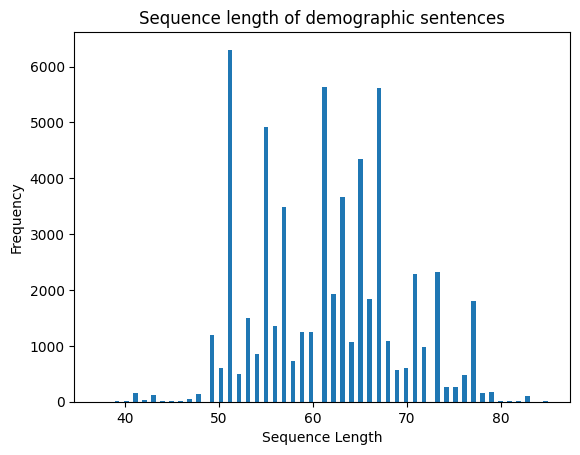

In [35]:
plt.hist(df_sentences["sequence_length"], bins=100)
plt.xlabel("Sequence Length")
plt.ylabel("Frequency")
plt.title("Sequence length of demographic sentences")
plt.show()

In [36]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device: {device}")

Using device: cuda


In [37]:
biobert_tokenizer = AutoTokenizer.from_pretrained("dmis-lab/biobert-v1.1")
biobert_model = AutoModel.from_pretrained("dmis-lab/biobert-v1.1").to(device)

In [39]:
batch_size = 32
embeddings = []

for i in tqdm(range(0, len(df_sentences), batch_size)): 
    batch = df_sentences['sentence'][i:i + batch_size].tolist()

    inputs = biobert_tokenizer(batch, return_tensors="pt", padding=True, max_length=85).to(device)

    with torch.no_grad():
        outputs = biobert_model(**inputs)
    
    # (batch_size, sequence_length, hidden_size)
    batch_embedding = outputs.last_hidden_state[:, 0, :].cpu().numpy()
    embeddings.extend(batch_embedding)

df_sentences["embedding"] = embeddings

100%|██████████| 1867/1867 [00:41<00:00, 44.72it/s]


In [40]:
df_sentences

,subject_id,hadm_id,stay_id,sentence,sequence_length,embedding
0,10000032,29079034,39553978,"A Patient is 52 years old, Female, WHITE, 152....",51,"[-0.033864543, 0.13260451, -0.2856071, 0.17262..."
1,10000980,26913865,39765666,"A Patient is 73 years old, Female, BLACK, 152....",51,"[-0.012842793, 0.12255765, -0.29749775, 0.0824..."
2,10001217,24597018,37067082,"A Patient is 55 years old, Female, WHITE, 167....",55,"[-0.010952743, 0.1661963, -0.26729903, 0.13148..."
3,10001217,27703517,34592300,"A Patient is 55 years old, Female, WHITE, 167....",55,"[-0.0066398783, 0.16413444, -0.26645342, 0.127..."
4,10001884,26184834,37510196,"A Patient is 68 years old, Female, BLACK, 157....",51,"[-0.01762606, 0.11820734, -0.30160597, 0.10121..."
...,...,...,...,...,...,...
59738,19999287,22997012,37692584,"A Patient is 71 years old, Female, BLACK, 165....",58,"[-0.006863119, 0.11816445, -0.2875518, 0.02114..."
59739,19999442,26785317,32336619,"A Patient is 41 years old, Male, WHITE, 192.71...",61,"[-0.087422095, 0.020697609, -0.30070704, 0.138..."
59740,19999442,26785317,32336619,"A Patient is 41 years old, Male, WHITE, 192.71...",61,"[-0.08506036, 0.032635827, -0.28491005, 0.1273..."
59741,19999987,23865745,36195440,"A Patient is 57 years old, Female, UNKNOWN, un...",60,"[-0.105915554, -0.001447275, -0.2794704, 0.156..."


In [48]:
print("출력 벡터 차원: ", len(df_sentences.loc[0, 'embedding']))

출력 벡터 차원:  768


In [49]:
df_sentences.to_parquet("demographics_patient_sentences_info.parquet")